# Indirect solution of Dyson equation - without inversion

The electronic self-energy is obtained by solving the Dyson equation

$$ \Sigma(i\omega_{n}) = G_{0}^{-1}(i\omega_{n}) - G^{-1}(i\omega_{n}),$$
where $G_{0}(i\omega_{n})$ is the Weiss field and $G(i\omega_{n})$ is the full interacting Green's function.

The proposed scheme solves this equation indirectly by minimizing the residual,
$$ \mathrm{min}_{\Sigma(i\omega_{n})}\quad||G(i\omega_{n}) - G_{0}(i\omega_{n}) - G_{0}(i\omega_{n})\Sigma(i\omega_{n})G(i\omega_{n})||,$$
where inversion is not required. This avoids the numerical instability innate to the first equation. We have achieve this by using the discrete Lehmann representation (DLR) to represent all quantities and optimize the set of DLR coefficients that satisfy the high-frequency constraint on the self-energy

$$ \Sigma(i\omega_{n}\rightarrow\infty) = \Sigma_{\infty} + \frac{\Sigma_{1}}{i\omega_{n}} + \mathcal{O}(\omega_{n}^{-2})$$

The minimization algorithm is implemented as follows. The main inputs to the minimization routine are: $G_{0}(i\omega_{n})$, $G(i\omega_{n})$, and $\{ \Sigma_{\infty}, \Sigma_{1} \}$.

    1. Obtain DLR for G(tau) and G0(tau)
    2. Compute Sigma(iw) from G(iw) and G0(iw) obtained from DLRs.
    3. 



In [3]:
from pydlr import kernel, dlr
from triqs.gf import *
from h5 import HDFArchive
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

import matplotlib.pyplot as plt
plt.style.use('publish')

from dimer import *
from common import *

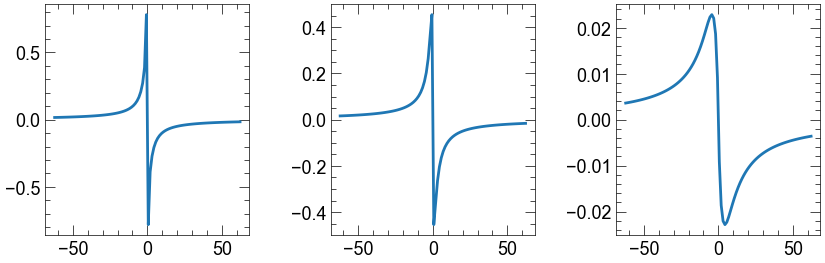

In [4]:
iwn = np.array([complex(x) for x in Sigma_iw_ref.mesh])
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].plot(iwn.imag, G0_iw['up'].data[:,0,0].imag)
ax[1].plot(iwn.imag, G_iw_ref['up'].data[:,0,0].imag)
ax[2].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag)
plt.subplots_adjust(wspace=0.4)

In [5]:
class Symmetrizer:

    def __init__(self, nx, no):
        self.N = (no*(no-1))//2
        self.nx, self.no = nx, no
        self.diag_idxs = np.arange(self.no)
        self.triu_idxs = np.triu_indices(no, k=1)
        self.tril_idxs = np.tril_indices(no, k=-1)
    
    def get_x_d(self, g_xaa):
        x_d = g_xaa[:, self.diag_idxs, self.diag_idxs].flatten()
        return x_d

    def set_x_d(self, g_xaa, x_d):
        g_xaa[:, self.diag_idxs, self.diag_idxs] = x_d.reshape((self.nx, self.no))
        return g_xaa

    def get_x_u(self, g_xaa):
        x_u = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].flatten()
        return x_u

    def set_x_u(self, g_xaa, x_u):
        g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]] = x_u.reshape((self.nx, self.N))
        g_xaa[:, self.tril_idxs[0], self.tril_idxs[1]] = g_xaa[:, self.triu_idxs[0], self.triu_idxs[1]].conj()
        #g_xaa += np.transpose(g_xaa, axes=(0,2,1)).conj()
        return g_xaa

    def get_diag_indices(self): return self.diag_idxs
    def get_triu_indices(self): return self.triu_idxs

In [76]:
def constrained_lstsq_dlr_from_tau(d, 
                                   tau_i,
                                   iw_i,
                                   beta, 
                                   g_iaa,     # G data
                                   g0_iaa,    # G0 data
                                   sigma_moments,
                                   ftol=1e-9, 
                                   symmetrizer=None):
    
    
    
    
    
    nx = len(d)
    ni, no, _ = g_iaa.shape
    shape_xaa = (nx, no, no)
    N = (no*(no-1))//2

    dtype = complex
    nX = nx * (no + 2*N)
    
    # fold and unfold complex numbers
    
    def merge_re_im(x):
        x_d, x_u = x[:nx*no], x[nx*no:]
        re, im = np.split(x_u, 2)
        x_u = re + 1.j * im
        return x_d, x_u

    def split_re_im(x_d, x_u):
        return np.concatenate((
            np.array(x_d.real, dtype=float),
            np.array(x_u.real, dtype=float),
            np.array(x_u.imag, dtype=float)))
                                   
    # Greens function <-> vector conversion

    sym = symmetrizer if symmetrizer is not None else Symmetrizer(nx, no)
    
    def g_from_x(x):
        x_d, x_u = merge_re_im(x)
        g_xaa = np.zeros((nx, no, no), dtype=dtype)
        sym.set_x_u(g_xaa, x_u)
        sym.set_x_d(g_xaa, x_d)
        return g_xaa
                        
    def x_from_g(g_xaa):
        x_d = sym.get_x_d(g_xaa)
        x_u = sym.get_x_u(g_xaa)
        x = split_re_im(x_d, x_u)
        return x
    
    
    # constraint
    sig_infty, sigma_1 = sigma_moments[0], sigma_moments[1]
        
    def mat_vec(mat):
        v_d = sym.get_x_d(mat[None, ...]).real
        v_u = sym.get_x_u(mat[None, ...])
        v = split_re_im(v_d, v_u)
        return v
        
    def constraint_func(x):
        sig = g_from_x(x)
        mat = -sig.sum(axis=0)
        vec = mat_vec(mat)
        return vec
    
    bound = mat_vec(sigma_1)
    
    constraints = (NonlinearConstraint(constraint_func,
                                           bound, bound))


    # target functions
    
    def dyson_difference(x_sig, x, x0):
        # G - G0 - G0*Σ*G = 0
        
        g_xaa = g_from_x(x)
        g0_xaa = g_from_x(x0)
        sig_xaa = g_from_x(x_sig)
        
        # evaulate G, G0, Sigma on DLR nodes
        g_waa = d.eval_dlr_freq(g_xaa, iw_i, beta)
        g0_waa = d.eval_dlr_freq(g0_xaa, iw_i, beta)
        sig_waa = d.eval_dlr_freq(sig_xaa, iw_i, beta) + sig_infty
        
        err_waa = g_waa - g0_waa - g0_waa[:,...]@sig_waa[:,...]@g_waa[:,...]
        
        return err_waa.flatten()
        
    def target_function(x_sig, x, x0):
        y = dyson_difference(x_sig, x, x0)
        # replace with the L2(τ) norm
        return np.linalg.norm(y) 
    
    # initial dlr fit to G and G0
    g_init_xaa = d.lstsq_dlr_from_tau(tau_i, g_iaa, beta)
    g0_init_xaa = d.lstsq_dlr_from_tau(tau_i, g0_iaa, beta)
    sig_init_xaa = np.empty_like(g_init_xaa) #- sig_infty
    #sig_init_xaa = d.lstq_dlr_from_matsubara(iw_i, sig_iaa, beta) - sig_infty

    x_init  = x_from_g(g_init_xaa)         # DLR coeffs of G(tau)
    x0_init = x_from_g(g0_init_xaa)        # DLR coeffs of G0(tau
    sig_init = x_from_g(sig_init_xaa)      # DLR coeffs of Σ(iwn)-Σoo.

    
    sol = minimize(target_function, sig_init,
        args=(x_init, x0_init),
        method='SLSQP', 
        constraints=constraints,
        options=dict(ftol=ftol, maxiter=1000, disp=True),
        )
    print(sol.success, sol.message)

    return g_from_x(sol.x), sol

In [77]:
def fit_dlr(d, iw, G_tau, G0_tau, Sigma_moments, ftol=1e-8):
    
    tau = np.array([float(x) for x in G_tau.mesh])
    
    beta = G_tau.mesh.beta
    sig_xaa = {}
 
    for block, gf in G_tau:
        
        sig_xaa[block], sol = constrained_lstsq_dlr_from_tau(d, tau, iw, beta,
                                                         G_tau[block].data, 
                                                         G0_tau[block].data,
                                                         Sigma_moments[block],
                                                         ftol=ftol,
                                                        )
    return sig_xaa

In [78]:
sigma_moments = sigma_high_frequency_moments(dm, hdiag, gf_struct, h_int)

In [79]:
d = dlr(lamb=30)

In [80]:
G0_tau = make_gf_from_fourier(G0_iw)

In [81]:
tau_i = np.array([x.real for x in G0_tau.mesh])
iw_i  = np.array([complex(x) for x in Sigma_iw_ref.mesh])

In [82]:
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                   tau_i, 
                                   iw_i,
                                   beta,
                                   G_tau_ref['up'].data,
                                   G0_tau['up'].data,
                                   sigma_moments['up'],
                                   ftol=1e-9, 
                                   symmetrizer=None)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.452116885716413e-06
            Iterations: 127
            Function evaluations: 13444
            Gradient evaluations: 127
True Optimization terminated successfully


In [83]:
Sigma_iw_fit = Sigma_iw_ref.copy()
Sigma_iw_fit['up'].data[:] = d.eval_dlr_freq(sig_xaa, iw_i, beta) +sigma_moments['up'][0]

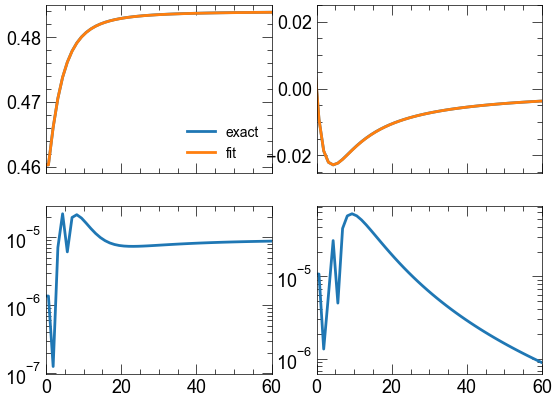

In [84]:
fig, ax = plt.subplots(2,2,sharex=True)
ax[0,0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, label='exact')
ax[0,0].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].real, label='fit')
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_fit['up'].data[:,0,0].real))
ax[0,0].legend()
ax[0,1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, label='exact')
ax[0,1].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].imag, label='fit')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_fit['up'].data[:,0,0].imag))
ax[0,0].legend()
ax[0,0].set_xlim(0,60)
plt.show()

In [119]:
tol = 5e-4
G_tau_qmc= G_tau_ref.copy()
G_tau_qmc['up'].data[:] += np.random.normal(scale=tol, size=G_tau_qmc['up'].data.shape)
d = dlr(lamb=30,eps=0.1*tol)

In [120]:
sig_xaa, sol = constrained_lstsq_dlr_from_tau(d, 
                                   tau_i,
                                   iw_i,
                                   beta, 
                                   G_tau_qmc['up'].data,
                                   G0_tau['up'].data,
                                   sigma_moments['up'],
                                   ftol=1e-9, 
                                   symmetrizer=None)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0010305505136314055
            Iterations: 125
            Function evaluations: 4647
            Gradient evaluations: 125
True Optimization terminated successfully


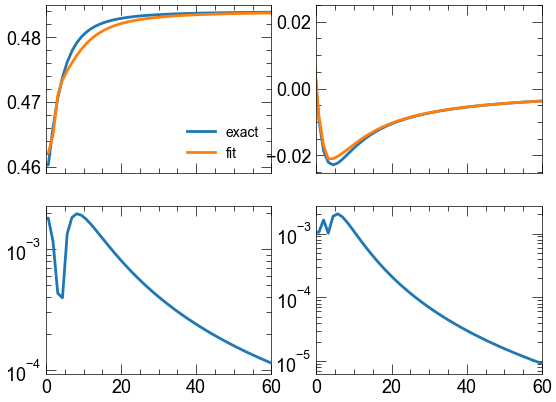

In [121]:
Sigma_iw_fit = Sigma_iw_ref.copy()
Sigma_iw_fit['up'].data[:] = d.eval_dlr_freq(sig_xaa, iw_i, beta)+sigma_moments['up'][0]

fig, ax = plt.subplots(2,2,sharex=True)
ax[0,0].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].real, label='exact')
ax[0,0].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].real, label='fit')
ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].real-Sigma_iw_fit['up'].data[:,0,0].real))
ax[0,0].legend()
ax[0,1].plot(iwn.imag, Sigma_iw_ref['up'].data[:,0,0].imag, label='exact')
ax[0,1].plot(iwn.imag, Sigma_iw_fit['up'].data[:,0,0].imag, label='fit')
ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref['up'].data[:,0,0].imag-Sigma_iw_fit['up'].data[:,0,0].imag))
ax[0,0].legend()
ax[0,0].set_xlim(0,60)
plt.show()

In [122]:
tol = 1e-3
G_tau_qmc= G_tau_ref.copy()
G_tau_qmc['up'].data[:] += np.random.normal(scale=tol, size=G_tau_qmc['up'].data.shape)
d = dlr(lamb=20,eps=1e-4)
sig_xaa = fit_dlr(d, iw_i, G_tau_qmc, G0_tau, sigma_moments)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0017095823621497775
            Iterations: 84
            Function evaluations: 2796
            Gradient evaluations: 84
True Optimization terminated successfully
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0016547494237429267
            Iterations: 57
            Function evaluations: 1902
            Gradient evaluations: 57
True Optimization terminated successfully


In [123]:
Sigma_iw_fit = Sigma_iw_ref.copy()
for block, sig in Sigma_iw_fit: Sigma_iw_fit[block].data[:] = d.eval_dlr_freq(sig_xaa[block], iw_i, beta)+sigma_moments[block][0]

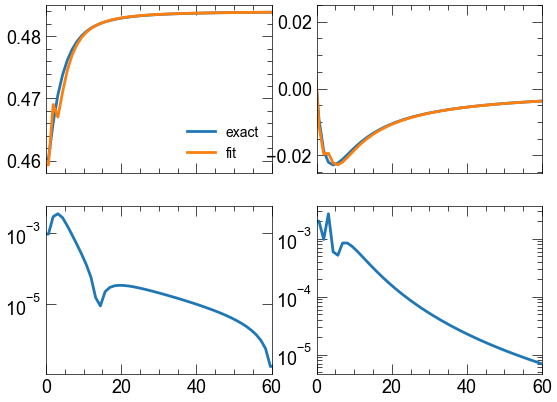

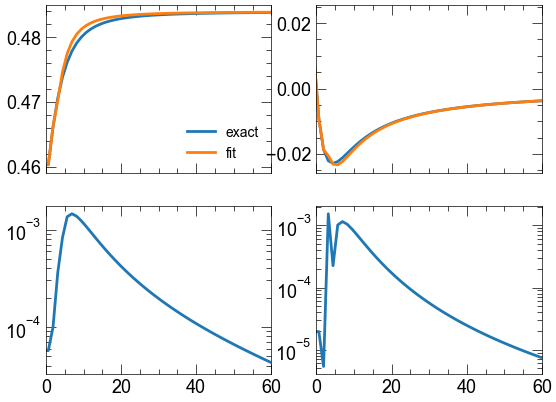

In [124]:
for block, sig in Sigma_iw_fit:
    fig, ax = plt.subplots(2,2,sharex=True)
    ax[0,0].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].real, label='exact')
    ax[0,0].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].real, label='fit')
    ax[1,0].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].real-Sigma_iw_fit[block].data[:,0,0].real))
    ax[0,0].legend()
    ax[0,1].plot(iwn.imag, Sigma_iw_ref[block].data[:,0,0].imag, label='exact')
    ax[0,1].plot(iwn.imag, Sigma_iw_fit[block].data[:,0,0].imag, label='fit')
    ax[1,1].semilogy(iwn.imag, np.abs(Sigma_iw_ref[block].data[:,0,0].imag-Sigma_iw_fit[block].data[:,0,0].imag))
    ax[0,0].legend()
    ax[0,0].set_xlim(0,60)
plt.show()